In [48]:
from pennylane import numpy as np
import matplotlib as mpl

np.random.seed(1359)

In [49]:
def _make_circular_data(num_sectors):
    """Generate datapoints arranged in an even circle."""
    center_indices = np.array(range(0, num_sectors))
    sector_angle = 2 * np.pi / num_sectors
    angles = (center_indices + 0.5) * sector_angle
    x = 0.7 * np.cos(angles)
    y = 0.7 * np.sin(angles)
    labels = 2 * np.remainder(np.floor_divide(angles, sector_angle), 2) - 1

    return x, y, labels


def make_double_cake_data(num_sectors):
    x1, y1, labels1 = _make_circular_data(num_sectors)
    x2, y2, labels2 = _make_circular_data(num_sectors)

    # x and y coordinates of the datapoints
    x = np.hstack([x1, 0.5 * x2])
    y = np.hstack([y1, 0.5 * y2])

    # Canonical form of dataset
    X = np.vstack([x, y]).T

    labels = np.hstack([labels1, -1 * labels2])

    # Canonical form of labels
    Y = labels.astype(int)

    return X, Y


In [50]:
def plot_double_cake_data(X, Y, ax, num_sectors=None):
    """Plot double cake data and corresponding sectors."""
    x, y = X.T
    cmap = mpl.colors.ListedColormap(["#FF0000", "#0000FF"])
    ax.scatter(x, y, c=Y, cmap=cmap, s=25, marker="s")

    if num_sectors is not None:
        sector_angle = 360 / num_sectors
        for i in range(num_sectors):
            color = ["#FF0000", "#0000FF"][(i % 2)]
            other_color = ["#FF0000", "#0000FF"][((i + 1) % 2)]
            ax.add_artist(
                mpl.patches.Wedge(
                    (0, 0),
                    1,
                    i * sector_angle,
                    (i + 1) * sector_angle,
                    lw=0,
                    color=color,
                    alpha=0.1,
                    width=0.5,
                )
            )
            ax.add_artist(
                mpl.patches.Wedge(
                    (0, 0),
                    0.5,
                    i * sector_angle,
                    (i + 1) * sector_angle,
                    lw=0,
                    color=other_color,
                    alpha=0.1,
                )
            )
            ax.set_xlim(-1, 1)

    ax.set_ylim(-1, 1)
    ax.set_aspect("equal")
    ax.axis("off")

    return ax


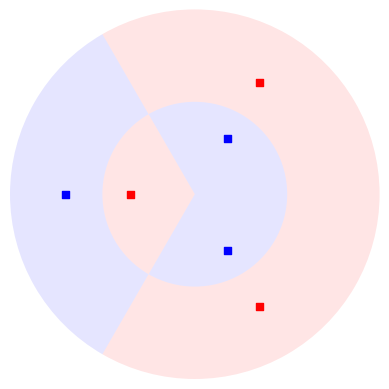

In [51]:
import matplotlib.pyplot as plt

num_sectors = 3
X, Y = make_double_cake_data(num_sectors)

ax = plot_double_cake_data(X, Y, plt.gca(), num_sectors=num_sectors)


In [52]:
import pennylane as qml


def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])
    
def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))


adjoint_ansatz = qml.adjoint(ansatz)


def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)


dev = qml.device("default.qubit", wires=5, shots=None)
wires = dev.wires.tolist()


@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires)

def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]




In [53]:
init_params = random_params(num_wires=5, num_layers=6)

In [54]:
kernel_value = kernel(X[0], X[1], init_params)
print(f"The kernel value between the first and second datapoint is {kernel_value:.3f}")


The kernel value between the first and second datapoint is 0.030


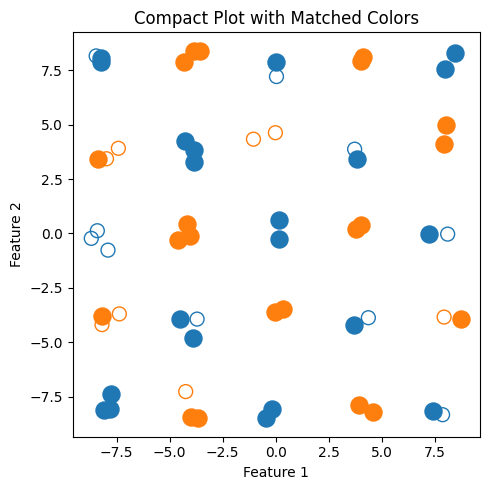

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

# Load the dataset
df = pd.read_csv('grid_like_pattern_dataset.csv')

# Separate features and target
X = df[['Feature 1', 'Feature 2']].values
y = df['Class'].values

# Correcting the classes to binary
y_binary = y % 2  # Convert to binary classes

# Convert classes to 1 and -1
y_binary = 2 * y_binary - 1  # Convert 0 to -1 and 1 to 1

# Split into training and testing sets
X_train, X_test, y_train_binary, y_test_binary = train_test_split(X, y_binary, test_size=0.3, random_state=42)

# Make the figure more compact by reducing spacing and size
plt.figure(figsize=(5, 5))

train_color_0 = '#1f77b4'  # Blue shade
train_color_1 = '#ff7f0e'  # Orange shade

# Plot training data with solid circles
plt.scatter(X_train[y_train_binary == -1][:, 0], X_train[y_train_binary == -1][:, 1], color=train_color_0, label='Train Class -1', s=150, marker='o', alpha=1)
plt.scatter(X_train[y_train_binary == 1][:, 0], X_train[y_train_binary == 1][:, 1], color=train_color_1, label='Train Class 1', s=150, marker='o', alpha=1)

# Plot testing data with hollow circles
plt.scatter(X_test[y_test_binary == -1][:, 0], X_test[y_test_binary == -1][:, 1], edgecolor=train_color_0, facecolor='none', label='Test Class -1', s=100, marker='o', alpha=1)
plt.scatter(X_test[y_test_binary == 1][:, 0], X_test[y_test_binary == 1][:, 1], edgecolor=train_color_1, facecolor='none', label='Test Class 1', s=100, marker='o', alpha=1)

# Remove extra margins for a tighter layout
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Checkerboard Data')
plt.tight_layout()
plt.savefig('data/checkerboard.png', dpi=800)
plt.show()

In [55]:
kernel_value = kernel(X_train[0], X_train[5], init_params)
print(f"The kernel value between the first and second datapoint is {kernel_value:.3f}")

The kernel value between the first and second datapoint is 0.009


In [56]:
init_kernel = lambda x1, x2: kernel(x1, x2, init_params)
K_init = qml.kernels.square_kernel_matrix(X_train, init_kernel, assume_normalized_kernel=True)

with np.printoptions(precision=3, suppress=True):
    print(K_init)

[[1.    0.034 0.013 ... 0.104 0.013 0.009]
 [0.034 1.    0.009 ... 0.005 0.019 0.027]
 [0.013 0.009 1.    ... 0.046 0.05  0.01 ]
 ...
 [0.104 0.005 0.046 ... 1.    0.005 0.1  ]
 [0.013 0.019 0.05  ... 0.005 1.    0.022]
 [0.009 0.027 0.01  ... 0.1   0.022 1.   ]]


In [57]:
from sklearn.svm import SVC
svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X_train, y_train_binary)

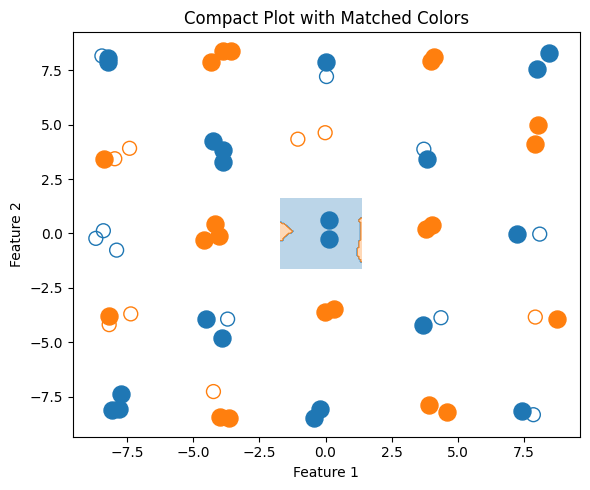

In [61]:
# Define the plot area
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))

# Predict the decision function for each point in the grid
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting the decision boundary and training/testing data
plt.figure(figsize=(6, 5))

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap([train_color_0, train_color_1]))

train_color_0 = '#1f77b4'  # Blue shade
train_color_1 = '#ff7f0e'  # Orange shade

# Plot training data with solid circles
plt.scatter(X_train[y_train_binary == 0][:, 0], X_train[y_train_binary == 0][:, 1], color=train_color_0, label='Train Class 0', s=150, marker='o', alpha=1)
plt.scatter(X_train[y_train_binary == 1][:, 0], X_train[y_train_binary == 1][:, 1], color=train_color_1, label='Train Class 1', s=150, marker='o', alpha=1)

# Plot testing data with hollow circles
plt.scatter(X_test[y_test_binary == 0][:, 0], X_test[y_test_binary == 0][:, 1], edgecolor=train_color_0, facecolor='none', label='Test Class 0', s=100, marker='o', alpha=1)
plt.scatter(X_test[y_test_binary == 1][:, 0], X_test[y_test_binary == 1][:, 1], edgecolor=train_color_1, facecolor='none', label='Test Class 1', s=100, marker='o', alpha=1)

# Remove extra margins for a tighter layout
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Compact Plot with Matched Colors')
plt.tight_layout()
plt.savefig('data/initial_decesion_plot_tutorial.png', dpi=800)
plt.show()

In [62]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)


accuracy_init = accuracy(svm, X_train, y_train_binary)
print(f"The accuracy of the kernel with random parameters is {accuracy_init:.3f}")


The accuracy of the kernel with random parameters is 0.905


In [63]:
accuracy_init = accuracy(svm, X_test, y_test_binary)
print(f"The accuracy of the kernel with random parameters is {accuracy_init:.3f}")

The accuracy of the kernel with random parameters is 0.389


In [72]:
def plot_decision_boundaries(classifier, ax, N_gridpoints=20):
    _xx, _yy = np.meshgrid(np.linspace(-10, 10, N_gridpoints), np.linspace(-10, 10, N_gridpoints))

    _zz = np.zeros_like(_xx)
    for idx in np.ndindex(*_xx.shape):
        _zz[idx] = classifier.predict(np.array([_xx[idx], _yy[idx]])[np.newaxis, :])

    plot_data = {"_xx": _xx, "_yy": _yy, "_zz": _zz}
    ax.contourf(
        _xx,
        _yy,
        _zz,
        cmap=mpl.colors.ListedColormap(["#FF0000", "#0000FF"]),
        alpha=0.2,
        levels=[-1, 0, 1],
    )
    
    train_color_0 = '#1f77b4'  # Blue shade
    train_color_1 = '#ff7f0e'  # Orange shade

    # Plot training data with solid circles
    plt.scatter(X_train[y_train_binary == 0][:, 0], X_train[y_train_binary == 0][:, 1], color=train_color_0, label='Train Class 0', s=150, marker='o', alpha=1)
    plt.scatter(X_train[y_train_binary == 1][:, 0], X_train[y_train_binary == 1][:, 1], color=train_color_1, label='Train Class 1', s=150, marker='o', alpha=1)

    # Plot testing data with hollow circles
    plt.scatter(X_test[y_test_binary == 0][:, 0], X_test[y_test_binary == 0][:, 1], edgecolor=train_color_0, facecolor='none', label='Test Class 0', s=100, marker='o', alpha=1)
    plt.scatter(X_test[y_test_binary == 1][:, 0], X_test[y_test_binary == 1][:, 1], edgecolor=train_color_1, facecolor='none', label='Test Class 1', s=100, marker='o', alpha=1)

    # Remove extra margins for a tighter layout
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Compact Plot with Matched Colors')
    plt.tight_layout()
    plt.savefig('data/initial_decesion_plot_tutorial.png', dpi=800)
    plt.show()

    return plot_data


In [64]:
kta_init = qml.kernels.target_alignment(X_train, y_train_binary, init_kernel, assume_normalized_kernel=True)
print(f"The kernel-target alignment for our dataset and random parameters is {kta_init:.3f}")

The kernel-target alignment for our dataset and random parameters is 0.256


In [79]:
def target_alignment(
    X,
    Y,
    kernel,
    assume_normalized_kernel=False,
    rescale_class_labels=True,
):
    """Kernel-target alignment between kernel and labels."""

    K = qml.kernels.square_kernel_matrix(
        X,
        kernel,
        assume_normalized_kernel=assume_normalized_kernel,
    )

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product


params = init_params
opt = qml.GradientDescentOptimizer(0.2)

for i in range(1000):
    # Choose subset of datapoints to compute the KTA on.
    subset = np.random.choice(list(range(len(X_train))), 4)
    # Define the cost function for optimization
    cost = lambda _params: -target_alignment(
        X_train[subset],
        y_train_binary[subset],
        lambda x1, x2: kernel(x1, x2, _params),
        assume_normalized_kernel=True,
    )
    # Optimization step
    params = opt.step(cost, params)

    # Report the alignment on the full dataset every 50 steps.
    if (i + 1) % 50 == 0:
        current_alignment = target_alignment(
            X_train,
            y_train_binary,
            lambda x1, x2: kernel(x1, x2, params),
            assume_normalized_kernel=True,
        )
        print(f"Step {i+1} - Alignment = {current_alignment:.3f}")


Step 50 - Alignment = 0.099
Step 100 - Alignment = 0.100
Step 150 - Alignment = 0.102
Step 200 - Alignment = 0.104
Step 250 - Alignment = 0.105
Step 300 - Alignment = 0.107
Step 350 - Alignment = 0.108
Step 400 - Alignment = 0.109
Step 450 - Alignment = 0.109
Step 500 - Alignment = 0.110
Step 550 - Alignment = 0.111
Step 600 - Alignment = 0.112
Step 650 - Alignment = 0.113
Step 700 - Alignment = 0.113
Step 750 - Alignment = 0.114
Step 800 - Alignment = 0.115
Step 850 - Alignment = 0.116
Step 900 - Alignment = 0.116
Step 950 - Alignment = 0.117
Step 1000 - Alignment = 0.117


In [80]:
# First create a kernel with the trained parameter baked into it.
trained_kernel = lambda x1, x2: kernel(x1, x2, params)
# Second create a kernel matrix function using the trained kernel.
trained_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, trained_kernel)
# Note that SVC expects the kernel argument to be a kernel matrix function.
svm_trained = SVC(kernel=trained_kernel_matrix).fit(X_train, y_train_binary)

In [81]:
accuracy_trained = accuracy(svm_trained, X_train, y_train_binary)
print(f"The accuracy of a kernel with trained parameters is {accuracy_trained:.3f}")

The accuracy of a kernel with trained parameters is 0.929


In [82]:
accuracy_trained = accuracy(svm_trained, X_test, y_test_binary)
print(f"The accuracy of a kernel with trained parameters is {accuracy_trained:.3f}")

The accuracy of a kernel with trained parameters is 0.389


In [83]:
# Define the plot area
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict the decision function for each point in the grid
Z = svm_trained.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting the decision boundary and training/testing data
plt.figure(figsize=(5, 5))

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap([train_color_0, train_color_1]))

train_color_0 = '#1f77b4'  # Blue shade
train_color_1 = '#ff7f0e'  # Orange shade

# Plot training data with solid circles
plt.scatter(X_train[y_train_binary == -1][:, 0], X_train[y_train_binary == -1][:, 1], color=train_color_0, label='Train Class -1', s=150, marker='o', alpha=1)
plt.scatter(X_train[y_train_binary == 1][:, 0], X_train[y_train_binary == 1][:, 1], color=train_color_1, label='Train Class 1', s=150, marker='o', alpha=1)

# Plot testing data with hollow circles
plt.scatter(X_test[y_test_binary == -1][:, 0], X_test[y_test_binary == -1][:, 1], edgecolor=train_color_0, facecolor='none', label='Test Class -1', s=100, marker='o', alpha=1)
plt.scatter(X_test[y_test_binary == 1][:, 0], X_test[y_test_binary == 1][:, 1], edgecolor=train_color_1, facecolor='none', label='Test Class 1', s=100, marker='o', alpha=1)

# Remove extra margins for a tighter layout
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Checkerboard Data')
plt.tight_layout()
plt.show()

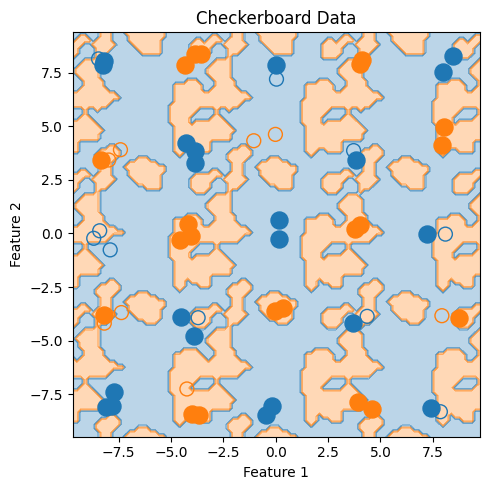

In [78]:
plt.figure(figsize=(5, 5))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap([train_color_0, train_color_1]))



train_color_0 = '#1f77b4'  # Blue shade
train_color_1 = '#ff7f0e'  # Orange shade

# Plot training data with solid circles
plt.scatter(X_train[y_train_binary == -1][:, 0], X_train[y_train_binary == -1][:, 1], color=train_color_0, label='Train Class -1', s=150, marker='o', alpha=1)
plt.scatter(X_train[y_train_binary == 1][:, 0], X_train[y_train_binary == 1][:, 1], color=train_color_1, label='Train Class 1', s=150, marker='o', alpha=1)

# Plot testing data with hollow circles
plt.scatter(X_test[y_test_binary == -1][:, 0], X_test[y_test_binary == -1][:, 1], edgecolor=train_color_0, facecolor='none', label='Test Class -1', s=100, marker='o', alpha=1)
plt.scatter(X_test[y_test_binary == 1][:, 0], X_test[y_test_binary == 1][:, 1], edgecolor=train_color_1, facecolor='none', label='Test Class 1', s=100, marker='o', alpha=1)

# Remove extra margins for a tighter layout
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Checkerboard Data')
plt.tight_layout()
plt.show()